# Chapter 4 前馈神经网络

In [2]:
import torch
import numpy as np
import pandas as pd
import os
import math
from matplotlib import pyplot as plt
class Op(object):
    def __init__(self):
        pass

    def __call__(self, inputs):
        return self.forward(inputs)
    
    def forward(self, inputs):
        raise NotImplementedError
    
    def backward(self, outputs_grads):
        raise NotImplementedError

from abc import abstractmethod

class Optimizer(object):
    def __init__(self, init_lr, model):
        self.init_lr = init_lr
        self.model = model

    @abstractmethod
    def step(self):
        pass

def accuracy(preds, labels):
    if preds.shape[1] == 1:
        preds = (preds>=0.5).to(torch.float32)
    else:
        preds = torch.argmax(preds, dim=1)
    return torch.mean((preds == labels).to(torch.float32))

# 构建二分类数据集 Moon1000 数据集
def make_moons(n_samples=100, shuffle=True, noise=None):
    """
    input:
        n_samples: 生成样本数量
        shuffle: 是否打乱数据
        noise: 噪声, None 或 float
    output:
        X: shape=[n_samples, 2]
        y: shape=[n_samples]
    """
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out
    # 采集第1类特征
    outer_circ_x = torch.cos(torch.linspace(0, math.pi, n_samples_out))
    outer_circ_y = torch.sin(torch.linspace(0, math.pi, n_samples_out))
    # 采集第2类特征
    inner_circ_x = 1 - torch.cos(torch.linspace(0, math.pi, n_samples_out))
    inner_circ_y = 0.5 - torch.sin(torch.linspace(0, math.pi, n_samples_out))

    X = torch.stack([torch.concat((outer_circ_x, inner_circ_x), dim=0), torch.concat((outer_circ_y, inner_circ_y), dim=0)], dim=1)
    y = torch.concat((torch.zeros(size=[n_samples_out]), torch.ones(size=[n_samples_in])))

    if shuffle:
        idx = torch.randperm(n_samples)
        X = X[idx]
        y = y[idx]
    if noise is not None:
        X += torch.normal(mean=0.0, std=noise, size=X.shape)
    
    return X, y.reshape([-1, 1])

## 4.1 神经元

**Sigmoid型函数**
$$\sigma(z)=\frac{1}{1+\exp(-z)}$$
$${\rm{tanh}}(z)=\frac{\exp(z)-\exp(-z)}{\exp(z)+\exp(-z)}$$

In [3]:
# Logistic 函数
def logistic(z):
    return 1. / (1. + torch.exp(-z))

# tanh 函数
def tanh(z):
    return (torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z))

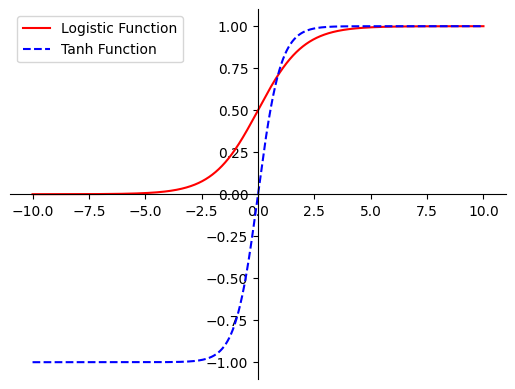

In [4]:
z = torch.linspace(-10, 10, 10000)
plt.figure()
plt.plot(z.tolist(), logistic(z).tolist(), color='r', label='Logistic Function')
plt.plot(z.tolist(), tanh(z).tolist(), color='b', linestyle='--', label='Tanh Function')
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
plt.legend()
plt.show()

**ReLU函数**
$${\rm{ReLU}}(z)=\max(0,z)$$
$${\rm{LeakyReLU}}(z)=\max(0,z)+\lambda \min(0,z)$$
其中 $\lambda$ 为超参数

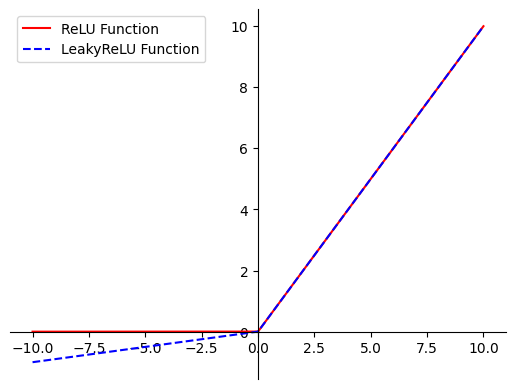

In [5]:
def relu(z):
    return torch.maximum(z, torch.tensor(0.))

def leaky_relu(z, negative_slope=0.1):
    a1 = (z > 0) * z
    a2 = (z <= 0) * z * negative_slope
    return a1 + a2

z = torch.linspace(-10, 10, 10000)
plt.figure()
plt.plot(z.tolist(), relu(z).tolist(), color='r', label='ReLU Function')
plt.plot(z.tolist(), leaky_relu(z).tolist(), color='b', linestyle='--', label='LeakyReLU Function')
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
plt.legend()
plt.show()

## 4.2 基于前馈神经网络的二分类任务

In [6]:
class Linear(Op):
    def __init__(self, input_size, output_size, name, weight_init=torch.nn.init.normal_, bias_init=torch.zeros):
        self.params = {}
        self.params['W'] = weight_init(torch.empty([input_size, output_size]))
        self.params['b'] = bias_init(size=[1, output_size])
        self.inputs = None
        self.grads = {}
        self.name = name
    
    def forward(self, inputs):
        self.inputs = inputs
        outputs = torch.matmul(inputs, self.params['W']) + self.params['b']
        return outputs
    
    def backward(self, grads):
        
        self.grads['W'] = torch.matmul(self.inputs.t(), grads)
        self.grads['b'] = torch.sum(grads, dim=0)
        # print("Linear W_grads_shape:", self.grads['W'].shape, "b_grads_shape:", self.grads['b'].shape)
        # print("Linear grads_shape:", grads.shape)
        return torch.matmul(grads, self.params['W'].t())

class Logistic(Op):
    def __init__(self):
        self.inputs = None
        self.outputs = None
        self.params = None
    
    def forward(self, inputs):
        self.outputs = 1. / (1. + torch.exp(-inputs))
        return self.outputs
    
    def backward(self, outputs_grads):
        outputs_grad_inputs = torch.multiply(self.outputs, (1.0 - self.outputs))
        # print("Logistic:", self.outputs.shape, outputs_grad_inputs.shape) #del
        return torch.multiply(outputs_grads, outputs_grad_inputs)

In [7]:
class Model_MLP_L2(Op):
    def __init__(self, input_size, hidden_size, output_size):
        self.fc1 = Linear(input_size=input_size, output_size=hidden_size, name="fc1")
        self.act_fn1 = Logistic()
        self.fc2 = Linear(input_size=hidden_size, output_size=output_size, name="fc2")
        self.act_fn2 = Logistic()
        self.layers = [self.fc1, self.act_fn1, self.fc2, self.act_fn2]
    
    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        return a2
    
    def backward(self, loss_grad_a2):
        # print("loss_grad_a2 shape:", loss_grad_a2.shape)
        loss_grad_z2 = self.act_fn2.backward(loss_grad_a2)
        # print("loss_grad_z2 shape:", loss_grad_z2.shape)
        loss_grad_a1 = self.fc2.backward(loss_grad_z2)
        # print("loss_grad_a1 shape:", loss_grad_a1.shape)
        loss_grad_z1 = self.act_fn1.backward(loss_grad_a1)
        loss_grad_inputs = self.fc1.backward(loss_grad_z1)

In [8]:
model = Model_MLP_L2(input_size=5, hidden_size=10, output_size=1)
X = torch.rand([1, 5])
result = model(X)
print("result:", result)

result: tensor([[0.8291]])


In [9]:
class BinaryCrossEntropyLoss(Op):
    def __init__(self, model):
        self.predicts = None
        self.labels = None
        self.num = None

        self.model = model

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)
    
    def forward(self, predicts, labels):
        self.predicts = predicts
        self.labels = labels
        self.num = predicts.shape[0]

        loss = -1. / self.num * (torch.matmul(labels.t(), torch.log(predicts)) + torch.matmul((1 - labels).t(), torch.log(1 - predicts)))

        # print("loss:", loss.shape) #del
        # loss = torch.squeeze(loss, dim=1)
        return loss
    
    def backward(self):
        # print("BinaryCrossEntropyLoss predicts_shape:", self.predicts.shape, "lables_shape:", self.labels.shape)
        inputs_grads = -1.0 * (self.labels / self.predicts - (1 - self.labels) / (1 - self.predicts)) / self.num
        # print("inputs_grad_shape:", inputs_grads.shape)
        self.model.backward(inputs_grads)

In [10]:
class BatchGD(Optimizer):
    def __init__(self, init_lr, model):
        super(BatchGD, self).__init__(init_lr=init_lr, model=model)
    
    def step(self):
        for layer in self.model.layers:
            if isinstance(layer.params, dict):
                for key in layer.params.keys():
                    layer.params[key] -= self.init_lr * layer.grads[key]

In [11]:
class RunnerV2_1(object):
    def __init__(self, model, optimizer, metric, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.metric = metric
        self.loss_fn = loss_fn
        
        self.train_scores = []
        self.val_scores = []

        self.train_loss = []
        self.val_loss = []

    def train(self, train_dataset, val_dataset, **kwargs):
        num_epochs = kwargs.get("num_epochs", 0)
        log_epochs = kwargs.get("log_epochs", 100)
        save_dir = kwargs.get("save_dir", "./checkpoint_bin")
        print_grads = kwargs.get("print_grads", None)
        best_score = 0

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for epoch in range(num_epochs):
            X, y = train_dataset
            logits = self.model(X)
            # print("logits shape:", logits.shape, "y shape:", y.shape) #del
            train_loss = self.loss_fn(logits, y).item()
            self.train_loss.append(train_loss)

            train_score = self.metric(logits, y).item()
            self.train_scores.append(train_score)

            self.loss_fn.backward()
            if print_grads is not None:
                print_grads(self.model)
            self.optimizer.step()
            val_score, val_loss = self.evaluate(val_dataset)
            if val_score > best_score:
                if save_dir:
                    self.save_model(save_dir)
                print(f"[Evaluate] best accuracy performance has been updated: {best_score: .5f} --> {val_score: .5f}")
                best_score = val_score
            if log_epochs and epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}, loss: {train_loss}, score: {train_score}")
                print(f"[Validation] epoch: {epoch}, loss: {val_loss}, score: {val_score}")

    def evaluate(self, dataset):
        X, y = dataset
        logits = self.model(X)
        loss = self.loss_fn(logits, y).item()
        self.val_loss.append(loss)
        score = self.metric(logits, y).item()
        self.val_scores.append(score)
        return score, loss
    
    def predict(self, X):
        return self.model(X)
    
    def save_model(self, save_dir):
        for layer in self.model.layers:
            if isinstance(layer.params, dict):
                    torch.save(layer.params, os.path.join(save_dir, layer.name + "_params.pt"))
    
    def load_model(self, save_dir):
        model_file_names = os.listdir(save_dir)
        name_file_dict = {}
        for file_name in model_file_names:
            name = file_name.replace(".pt", "")
            name_file_dict[name] = os.path.join(save_dir, file_name)
        for layer in self.model.layers:
            if isinstance(layer.params, dict):
                layer.params = torch.load(name_file_dict[layer.name])

In [12]:
X, y = make_moons(n_samples=1000, shuffle=True, noise=0.2)
num_train = 640
num_val = 160
num_test = 200
X_train, y_train = X[:num_train], y[:num_train]
X_val, y_val = X[num_train:num_train + num_val], y[num_train:num_train + num_val]
X_test, y_test = X[num_train + num_val:], y[num_train + num_val:]

input_size = 2
hidden_size = 5
output_size = 1
model = Model_MLP_L2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
loss_fn = BinaryCrossEntropyLoss(model=model)
metric = accuracy
optimizer = BatchGD(init_lr=0.2, model=model)
runner = RunnerV2_1(model=model, optimizer=optimizer, metric=metric, loss_fn=loss_fn)
num_epochs = 1000
runner.train(train_dataset=[X_train, y_train], val_dataset=[X_val, y_val], num_epochs=num_epochs, log_epochs=50, save_dir="./checkpoint_bin_mlp")

[Evaluate] best accuracy performance has been updated:  0.00000 -->  0.53750
[Train] epoch: 0, loss: 0.8234977722167969, score: 0.5078125
[Validation] epoch: 0, loss: 0.7848707437515259, score: 0.5375000238418579
[Evaluate] best accuracy performance has been updated:  0.53750 -->  0.61875
[Train] epoch: 50, loss: 0.5808625221252441, score: 0.682812511920929
[Validation] epoch: 50, loss: 0.5874881744384766, score: 0.612500011920929
[Evaluate] best accuracy performance has been updated:  0.61875 -->  0.62500
[Evaluate] best accuracy performance has been updated:  0.62500 -->  0.63125
[Evaluate] best accuracy performance has been updated:  0.63125 -->  0.63750
[Evaluate] best accuracy performance has been updated:  0.63750 -->  0.64375
[Evaluate] best accuracy performance has been updated:  0.64375 -->  0.65000
[Evaluate] best accuracy performance has been updated:  0.65000 -->  0.65625
[Evaluate] best accuracy performance has been updated:  0.65625 -->  0.66250
[Evaluate] best accuracy p

[Evaluate] best accuracy performance has been updated:  0.68125 -->  0.68750
[Evaluate] best accuracy performance has been updated:  0.68750 -->  0.70000
[Evaluate] best accuracy performance has been updated:  0.70000 -->  0.70625
[Evaluate] best accuracy performance has been updated:  0.70625 -->  0.71875
[Evaluate] best accuracy performance has been updated:  0.71875 -->  0.72500
[Train] epoch: 100, loss: 0.4834151268005371, score: 0.7749999761581421
[Validation] epoch: 100, loss: 0.49661755561828613, score: 0.7250000238418579
[Evaluate] best accuracy performance has been updated:  0.72500 -->  0.73125
[Evaluate] best accuracy performance has been updated:  0.73125 -->  0.73750
[Evaluate] best accuracy performance has been updated:  0.73750 -->  0.74375
[Evaluate] best accuracy performance has been updated:  0.74375 -->  0.75000
[Evaluate] best accuracy performance has been updated:  0.75000 -->  0.75625
[Evaluate] best accuracy performance has been updated:  0.75625 -->  0.76250
[Ev

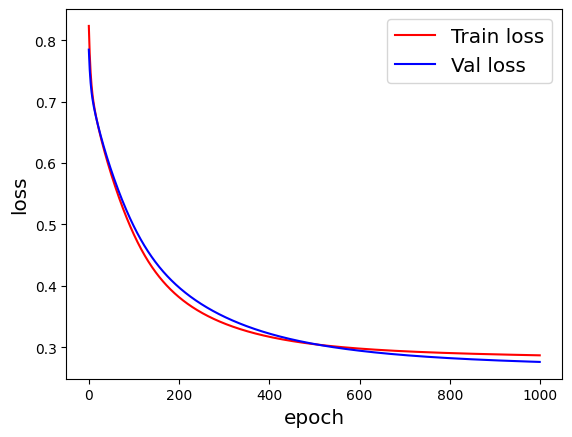

In [13]:
plt.figure()
plt.plot(range(num_epochs), runner.train_loss, color='r', label='Train loss')
plt.plot(range(num_epochs), runner.val_loss, color='b', label='Val loss')
plt.xlabel("epoch", fontsize='x-large')
plt.ylabel("loss", fontsize='x-large')
plt.legend(fontsize='x-large')
plt.show()

## 4.3 自动梯度计算和预定义算子

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import constant_, normal_, uniform_

class Model_MLP_L2_V2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_MLP_L2_V2, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size, bias=True)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size, bias=True)
        self.act_fn = F.sigmoid
    
    def forward(self, inputs):
        z1 = self.fc1(inputs)
        a1 = self.act_fn(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn(z2)
        return a2

In [32]:
class RunnerV2_2(object):
    def __init__(self, model, optimizer, metric, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.metric = metric
        self.loss_fn = loss_fn
        
        self.train_scores = []
        self.val_scores = []

        self.train_loss = []
        self.val_loss = []

    def train(self, train_dataset, val_dataset, **kwargs):
        self.model.train()
        num_epochs = kwargs.get("num_epochs", 0)
        log_epochs = kwargs.get("log_epochs", 100)
        save_dir = kwargs.get("save_dir", "./checkpoint_auto")
        custom_print_log = kwargs.get("custom_print_log", None)

        best_score = 0
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)
        for epoch in range(num_epochs):
            X, y = train_dataset
            logits = self.model(X)
            # print("logits shape:", logits.shape, "y shape:", y.shape) #del
            train_loss = self.loss_fn(logits, y)
            self.train_loss.append(train_loss.item())

            train_score = self.metric(logits, y)
            self.train_scores.append(train_score.item())

            train_loss.backward()

            if custom_print_log:
                custom_print_log(self.model)

            self.optimizer.step()
            self.optimizer.zero_grad()

            val_score, val_loss = self.evaluate(val_dataset)
            if val_score > best_score:
                if save_dir:
                    self.save_model(save_dir)
                print(f"[Evaluate] best accuracy performance has been updated: {best_score: .5f} --> {val_score: .5f}")
                best_score = val_score
            if log_epochs and epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}, loss: {train_loss}, score: {train_score}")
                print(f"[Validation] epoch: {epoch}, loss: {val_loss}, score: {val_score}")

    @torch.no_grad()
    def evaluate(self, dataset):
        self.model.eval()
        X, y = dataset
        logits = self.model(X)
        loss = self.loss_fn(logits, y).item()
        self.val_loss.append(loss)
        score = self.metric(logits, y).item()
        self.val_scores.append(score)
        return score, loss
    
    @torch.no_grad()
    def predict(self, X):
        self.model.eval()
        return self.model(X)
    
    def save_model(self, save_dir):
        torch.save(self.model, os.path.join(save_dir, "model.pt"))
    
    def load_model(self, model_dir):
        self.model = torch.load(model_dir)

input_size = 2
hidden_size = 5
output_size = 1
model = Model_MLP_L2_V2(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
loss_fn = F.binary_cross_entropy
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.2)
metric = accuracy
save_dir = './checkpoint_auto'
runner = RunnerV2_2(model=model, optimizer=optimizer, metric=metric, loss_fn=loss_fn)
runner.train(train_dataset=[X_train, y_train], val_dataset=[X_val, y_val], num_epochs=1000, log_epochs=50, save_dir=save_dir)

[Evaluate] best accuracy performance has been updated:  0.00000 -->  0.46250
[Train] epoch: 0, loss: 0.6946905255317688, score: 0.4921875
[Validation] epoch: 0, loss: 0.7000565528869629, score: 0.4625000059604645
[Evaluate] best accuracy performance has been updated:  0.46250 -->  0.55000
[Evaluate] best accuracy performance has been updated:  0.55000 -->  0.65625
[Evaluate] best accuracy performance has been updated:  0.65625 -->  0.71250
[Evaluate] best accuracy performance has been updated:  0.71250 -->  0.73750
[Evaluate] best accuracy performance has been updated:  0.73750 -->  0.76875
[Train] epoch: 50, loss: 0.6027539968490601, score: 0.7828124761581421
[Validation] epoch: 50, loss: 0.6090041995048523, score: 0.71875
[Train] epoch: 100, loss: 0.5062612295150757, score: 0.793749988079071
[Validation] epoch: 100, loss: 0.521689772605896, score: 0.7562500238418579
[Train] epoch: 150, loss: 0.4328834116458893, score: 0.8062499761581421
[Validation] epoch: 150, loss: 0.45476880669593

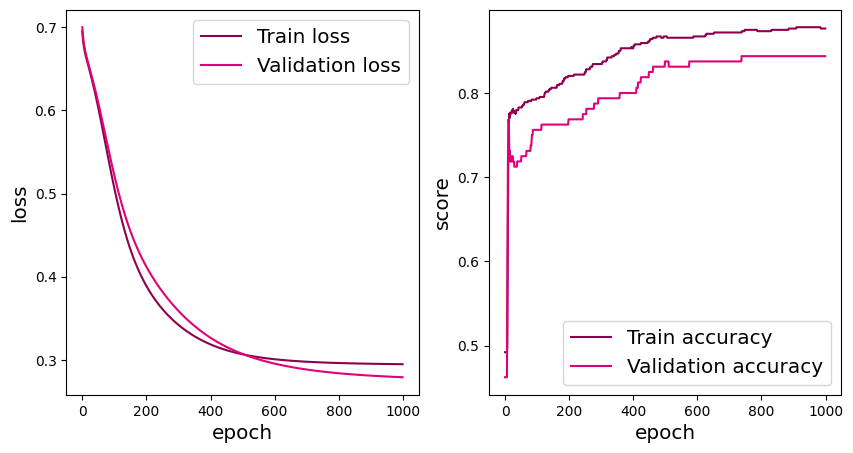

In [33]:
def plot(runner, fig_name=None):
    plt.figure(figsize=(10, 5))
    epochs = [i for i in range(len(runner.train_loss))]

    plt.subplot(1, 2, 1)
    plt.plot(epochs, runner.train_loss, color='#8E004D', label="Train loss")
    plt.plot(epochs, runner.val_loss, color='#E20079', label="Validation loss")
    plt.ylabel("loss", fontsize='x-large')
    plt.xlabel("epoch", fontsize='x-large')
    plt.legend(loc='upper right', fontsize='x-large')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, runner.train_scores, color='#8E004D', label="Train accuracy")
    plt.plot(epochs, runner.val_scores, color='#E20079', label="Validation accuracy")
    plt.ylabel("score", fontsize='x-large')
    plt.xlabel("epoch", fontsize='x-large')
    plt.legend(loc='lower right', fontsize='x-large')

    if fig_name:
        plt.savefig(fig_name)
    plt.show()
plot(runner)

In [34]:
runner.load_model(model_dir="./checkpoint_auto/model.pt")
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.8800/0.2986


## 4.4 优化问题

torch.Size([10000])
torch.Size([10000])


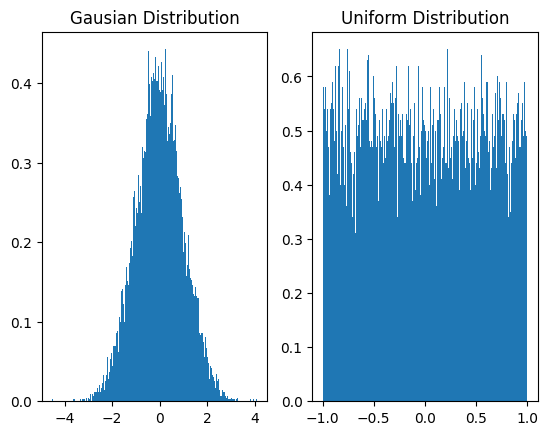

In [147]:
gausian_weights = normal_(tensor=torch.empty([10000]), mean=0.0, std=1.0)
uniform_weights = uniform_(tensor=torch.empty([10000]), a=-1.0, b=1.0)
print(gausian_weights.shape)
print(uniform_weights.shape)

plt.figure()
plt.subplot(1, 2, 1)
plt.title('Gausian Distribution')
plt.hist(gausian_weights.tolist(), bins=200, density=True)
plt.subplot(1, 2, 2)
plt.title('Uniform Distribution')
plt.hist(uniform_weights.tolist(), bins=200, density=True)
plt.show()

In [148]:
class Model_MLP_L5(nn.Module):
    def __init__(self, input_size, output_size, act='sigmoid', w_init=normal_, b_init=None):
        super(Model_MLP_L5, self).__init__()
        self.fc1 = nn.Linear(input_size, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 3)
        self.fc4 = nn.Linear(3, 3)
        self.fc5 = nn.Linear(3, output_size)
        self.act = act
        self.init_weights(w_init, b_init)
    
    def init_weights(self, w_init, b_init):
        for n, m in self.named_children():
            if isinstance(m, nn.Linear):
                w_init(m.weight)
                if b_init is None:
                    constant_(m.bias, val=1.0)
                else:
                    constant_(m.bias, val=b_init)

    def activation(self, inputs):
        if self.act == 'sigmoid':
            return F.sigmoid(inputs)
        elif self.act == 'relu':
            return F.relu(inputs)
        elif self.act == 'lrelu':
            return F.leaky_relu(input=inputs, negative_slope=0.2)
        else:
            raise ValueError("Please enter sigmoid relu or lrelu!")
    
    def forward(self, inputs):
        outputs = self.fc1(inputs)
        outputs = self.activation(outputs)
        outputs = self.fc2(outputs)
        outputs = self.activation(outputs)
        outputs = self.fc3(outputs)
        outputs = self.activation(outputs)
        outputs = self.fc4(outputs)
        outputs = self.activation(outputs)
        outputs = self.fc5(outputs)
        outputs = F.sigmoid(outputs)
        return outputs

In [149]:
def print_grads(model: nn.Module):
   print("The gradient of the Layers: ")
   for i, item in enumerate(model.children()):
      if isinstance(item, nn.Linear):
         print(item._get_name() + f"_{i}", torch.norm(item.get_parameter('weight').grad, p=2.).numpy())

In [150]:
torch.manual_seed(1002)

model = Model_MLP_L5(input_size=2, output_size=1, act='sigmoid')
optimizer = torch.optim.SGD(lr=0.01, params=model.parameters())
loss_fn = F.binary_cross_entropy
metric = accuracy
custom_print_log = print_grads

runner = RunnerV2_2(model=model, optimizer=optimizer, metric=metric, loss_fn=loss_fn)
runner.train([X_train, y_train], [X_val, y_val], num_epochs=1, log_epochs=None, custom_print_log=custom_print_log)

The gradient of the Layers: 
Linear_0 0.00041829492
Linear_1 0.0018793477
Linear_2 0.0126035325
Linear_3 0.075582296
Linear_4 0.39747086
[Evaluate] best accuracy performance has been updated:  0.00000 -->  0.46250


In [151]:
model = Model_MLP_L5(input_size=2, output_size=1, act='relu')

runner = RunnerV2_2(model=model, optimizer=optimizer, metric=metric, loss_fn=loss_fn)
runner.train([X_train, y_train], [X_val, y_val], num_epochs=1, log_epochs=None, custom_print_log=custom_print_log)

The gradient of the Layers: 
Linear_0 0.25631458
Linear_1 0.411088
Linear_2 0.90431666
Linear_3 0.1038061
Linear_4 0.7480404
[Evaluate] best accuracy performance has been updated:  0.00000 -->  0.46250


In [152]:
# 死亡ReLu
model = Model_MLP_L5(input_size=2, output_size=1, act='relu', b_init=-8.0)

runner = RunnerV2_2(model=model, optimizer=optimizer, metric=metric, loss_fn=loss_fn)
runner.train([X_train, y_train], [X_val, y_val], num_epochs=1, log_epochs=None, custom_print_log=custom_print_log)

The gradient of the Layers: 
Linear_0 0.0
Linear_1 0.0
Linear_2 0.0
Linear_3 0.0
Linear_4 0.0
[Evaluate] best accuracy performance has been updated:  0.00000 -->  0.53750


In [153]:
model = Model_MLP_L5(input_size=2, output_size=1, act='lrelu', b_init=-8.0)

runner = RunnerV2_2(model=model, optimizer=optimizer, metric=metric, loss_fn=loss_fn)
runner.train([X_train, y_train], [X_val, y_val], num_epochs=1, log_epochs=None, custom_print_log=custom_print_log)

The gradient of the Layers: 
Linear_0 0.0022116338
Linear_1 0.020437043
Linear_2 0.08179816
Linear_3 0.3565914
Linear_4 1.4549599
[Evaluate] best accuracy performance has been updated:  0.00000 -->  0.53750


## 4.5 实践：基于FFN完成鸢尾花分类任务

In [117]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os

def load_iris_data(shuffle=True):
    data = pd.read_csv("./dataset/Iris.csv")

    y = data["Species"].values
    y[y == 'Iris-setosa'] = 0
    y[y == 'Iris-versicolor'] = 1
    y[y == 'Iris-virginica'] = 2
    X = data.drop(["Id", "Species"], axis=1).values
    X = torch.tensor(X.tolist(), dtype=torch.float32)
    y = torch.tensor(y.tolist())

    X_max, index = torch.max(X, dim=0)
    X_min, index = torch.min(X, dim=0)
    X = (X - X_min) / (X_max - X_min)

    if shuffle:
        idx = torch.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]
    return X, y

class IrisDataset(Dataset):
    def __init__(self, mode='train', num_train=120, num_val=15):
        super(IrisDataset, self).__init__()
        X, y = load_iris_data(shuffle=True)
        if mode == 'train':
            self.X, self.y = X[:num_train], y[:num_train]
        elif mode == 'val':
            self.X, self.y = X[num_train:num_train + num_val], y[num_train:num_train + num_val]
        else:
            self.X, self.y = X[num_train + num_val:], y[num_train + num_val:]
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return len(self.y)


In [118]:
torch.manual_seed(10)
train_dataset = IrisDataset(mode='train')
val_dataset = IrisDataset(mode='val')
test_dataset = IrisDataset(mode='test')
print("length of train set:", len(train_dataset))

length of train set: 120


In [119]:
batch_size = 16
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [120]:
from torch import nn

class Model_MLP_L2_V3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model_MLP_L2_V3, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size, bias=True)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size, bias=True)
        self.act_fn = nn.Sigmoid()
    
    def forward(self, inputs):
        z1 = self.fc1(inputs)
        a1 = self.act_fn(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn(z2)
        return a2

fnn_model = Model_MLP_L2_V3(input_size=4, hidden_size=6, output_size=3)

In [121]:
from sklearn import metrics

class Accuracy(object):
    def __init__(self, is_logist=True):
        # is_logist: outputs是对率还是激活后的值
        self.num_correct =  0
        self.num_count = 0
        self.is_logist = is_logist
    
    def update(self, outputs, labels):
        """
        input:
            outputs: shape=[N, class_num]
            labels: shape=[N, 1]
        """
        if outputs.shape[1] == 1:
            outputs = torch.squeeze(outputs, -1)
            if self.is_logist:
                preds = torch.tensor(outputs >= 0, dtype=torch.float32)
            else:
                preds = torch.tensor(outputs >= 0.5, dtype=torch.float32)
        else:
            preds = torch.argmax(outputs, dim=1)
        
        labels = torch.squeeze(labels, -1)
        batch_correct = torch.sum(preds==labels).item()
        batch_count = labels.shape[0]
        # print(batch_correct, batch_count)

        self.num_correct += batch_correct
        self.num_count += batch_count

        # print("total:", self.num_correct, self.num_count)
    
    def accumulate(self):
        if self.num_count == 0:
            return 0
        # print("total:", self.num_correct, self.num_count)
        return self.num_correct / self.num_count
    
    def reset(self):
        self.num_correct = 0
        self.num_count = 0
    
    def name(self):
        return "Accuracy"

In [122]:
import torch.nn.functional as F
class RunnerV3(object):
    def __init__(self, model, optimizer, metric, loss_fn, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.metric = metric
        self.loss_fn = loss_fn
        
        self.val_scores = []

        self.train_epoch_losses = []
        self.train_step_losses = []
        self.val_losses = []

        self.best_score = 0

    def train(self, train_dataloader, val_dataloader=None, **kwargs):
        self.model.train()
        num_epochs = kwargs.get("num_epochs", 0)
        log_steps = kwargs.get("log_steps", 100)
        eval_steps = kwargs.get("eval_steps", 0)
        save_dir = kwargs.get("save_dir", "./checkpoint_auto")
        custom_print_log = kwargs.get("custom_print_log", None)

        num_training_steps = num_epochs * len(train_dataloader)

        if eval_steps:
            if self.metric is None:
                raise RuntimeError('Error: Metric can not be None!')
            if val_dataloader is None:
                raise RuntimeError('Error: val_loader can not be None!')

        global_step = 0

        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)
        for epoch in range(num_epochs):
            total_loss = 0
            for step, data in enumerate(train_dataloader):
                X, y = data
                logits = self.model(X)
                # print("logits shape:", logits.shape, "y shape:", y.shape) #del
                loss = self.loss_fn(logits, y)
                total_loss += loss
                self.train_step_losses.append((global_step, loss.item()))

                if log_steps and global_step % log_steps == 0:
                    print(f"[Train] epoch: {epoch}/{num_epochs}, step: {global_step}/{num_training_steps}, loss: {loss.item():.5f}")

                loss.backward()

                if custom_print_log:
                    custom_print_log(self.model)

                self.optimizer.step()
                self.optimizer.zero_grad()

                if eval_steps > 0 and global_step != 0 and \
                    (global_step % eval_steps == 0 or global_step == (num_training_steps - 1)):
                    val_score, val_loss = self.evaluate(val_dataloader, global_step=global_step)
                    print(f"[Evaluate] val score: {val_score:.5f}, val loss: {val_loss:.5f}")
                    self.model.train()

                    if val_score > self.best_score:
                        self.save_model(save_dir)
                        print(f"[Evaluate] best accuracy performance has been updated: {self.best_score:.5f}, val loss: {val_score:.5f}")
                        self.best_score = val_score

                global_step += 1
            train_loss = (total_loss / len(train_dataloader)).item()
            self.train_epoch_losses.append(train_loss)
        
        print("[Train] Training done!")

    @torch.no_grad()
    def evaluate(self, val_dataloader, **kwargs):
        assert self.metric is not None
        self.model.eval()
        global_step = kwargs.get("global_step", -1)
        total_loss = 0.
        self.metric.reset()
        
        for batch_id, data in enumerate(val_dataloader):
            X, y = data
            logits = self.model(X)
            loss = self.loss_fn(logits, y).item()
            total_loss += loss
            self.metric.update(logits, y)

        val_loss = total_loss / len(val_dataloader)
        print(f"val_loss: {val_loss}, total_loss: {total_loss}, len: {len(val_dataloader)}")
        self.val_losses.append((global_step, val_loss))
        val_score = self.metric.accumulate()
        self.val_scores.append(val_score)
        # print(self.val_scores)

        return val_score, val_loss
    
    @torch.no_grad()
    def predict(self, X):
        self.model.eval()
        return self.model(X)
    
    def save_model(self, save_dir):
        torch.save(self.model, os.path.join(save_dir, "model.pt"))
    
    def load_model(self, model_dir):
        self.model = torch.load(model_dir)

In [123]:
import torch.optim as opt
model = fnn_model
optimizer = opt.SGD(params=model.parameters(), lr=0.2)
loss_fn = F.cross_entropy
metric = Accuracy(is_logist=True)
runner = RunnerV3(model=model, optimizer=optimizer, metric=metric, loss_fn=loss_fn)
runner.train(train_dataloader, val_dataloader, num_epochs=200, log_steps=100, eval_steps=50, save_dir='./checkpoint_auto_Iris')

[Train] epoch: 0/200, step: 0/1600, loss: 1.11651
val_loss: 1.1173300743103027, total_loss: 1.1173300743103027, len: 1
[Evaluate] val score: 0.26667, val loss: 1.11733
[Evaluate] best accuracy performance has been updated: 0.00000, val loss: 0.26667
[Train] epoch: 12/200, step: 100/1600, loss: 1.08841
val_loss: 1.1071057319641113, total_loss: 1.1071057319641113, len: 1
[Evaluate] val score: 0.26667, val loss: 1.10711


val_loss: 1.1036717891693115, total_loss: 1.1036717891693115, len: 1
[Evaluate] val score: 0.26667, val loss: 1.10367
[Train] epoch: 25/200, step: 200/1600, loss: 1.10197
val_loss: 1.1015853881835938, total_loss: 1.1015853881835938, len: 1
[Evaluate] val score: 0.26667, val loss: 1.10159
val_loss: 1.0978626012802124, total_loss: 1.0978626012802124, len: 1
[Evaluate] val score: 0.26667, val loss: 1.09786
[Train] epoch: 37/200, step: 300/1600, loss: 1.09372
val_loss: 1.0946680307388306, total_loss: 1.0946680307388306, len: 1
[Evaluate] val score: 0.53333, val loss: 1.09467
[Evaluate] best accuracy performance has been updated: 0.26667, val loss: 0.53333
val_loss: 1.0936999320983887, total_loss: 1.0936999320983887, len: 1
[Evaluate] val score: 0.53333, val loss: 1.09370
[Train] epoch: 50/200, step: 400/1600, loss: 1.09074
val_loss: 1.087881326675415, total_loss: 1.087881326675415, len: 1
[Evaluate] val score: 0.53333, val loss: 1.08788
val_loss: 1.0837039947509766, total_loss: 1.083703994

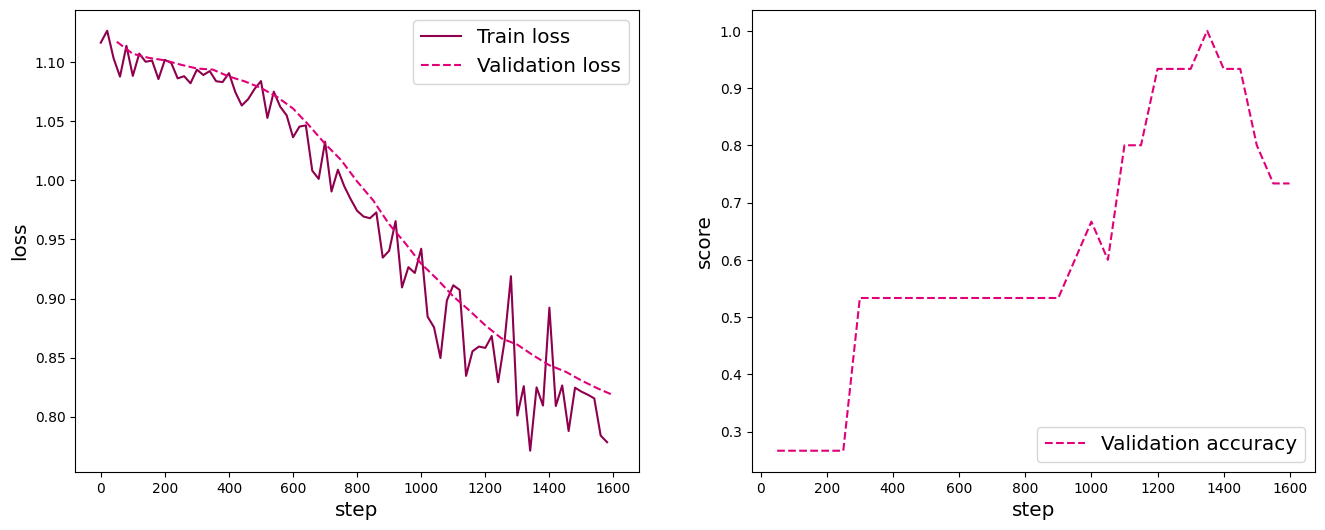

In [124]:
import matplotlib.pyplot as plt
def plot_training_loss_acc(runner, fig_name=None,
                           fig_size=(16, 6),
                           sample_step=20,
                           loss_legend_loc="upper right",
                           acc_legend_loc="lower right",
                           train_color="#8E004D",
                           val_color="#E20079",
                           fontsize='x-large',
                           train_linestyle='-',
                           val_linestyle='--'):
    plt.figure(figsize=fig_size)

    plt.subplot(1, 2, 1)
    train_items = runner.train_step_losses[::sample_step]
    train_steps = [x[0] for x in train_items]
    train_losses = [x[1] for x in train_items]

    plt.plot(train_steps, train_losses, color=train_color, linestyle=train_linestyle, label="Train loss")
    if len(runner.val_losses) > 0:
        val_steps = [x[0] for x in runner.val_losses]
        val_losses = [x[1] for x in runner.val_losses]
        plt.plot(val_steps, val_losses, color=val_color, linestyle=val_linestyle, label="Validation loss")
    
    plt.ylabel("loss", fontsize=fontsize)
    plt.xlabel("step", fontsize=fontsize)
    plt.legend(loc=loss_legend_loc, fontsize=fontsize)

    if len(runner.val_scores) > 0:
        plt.subplot(1, 2, 2)
        plt.plot(val_steps, runner.val_scores, color=val_color, linestyle=val_linestyle, label="Validation accuracy")
        plt.ylabel("score", fontsize=fontsize)
        plt.xlabel("step", fontsize=fontsize)
        plt.legend(loc=acc_legend_loc, fontsize=fontsize)  
    
    plt.show()
plot_training_loss_acc(runner)